## Implementation of a federated learning model using FedAvg on the MNIST Data set

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Define the parameters

In [4]:
clients = 15 # the number of clients
learningRounds = 18 # the number of communications between the clients and the global model
numEpochs = 5 # the number of local epochs
lr = 0.1 # training rate
device = torch.device("cpu")

# Download and preprocess the MNIST data set

In [6]:
# download the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainData = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testData = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testLoader = torch.utils.data.DataLoader(testData, batch_size=10, shuffle=False)
# Shuffle the data
indices = list(range(len(trainData)))
dataShuffled = [trainData[i] for i in indices]
# create equal-sized subsets for each client in an iid manner
clientData = []
# each client will get a sample of size 500
sampleSize = 500
for label in range(clients):
    if label == 1:
        labelData = dataShuffled
    elif label > 9:
        labelData = dataShuffled
    else:
        labelData = [data for data in dataShuffled if data[1] == label]
    subsetSize = min(len(labelData), sampleSize)
    dataClient = labelData[:subsetSize]
    clientData.append(dataClient)

# Define the global model

In [33]:
globalModel = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 12 * 12, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Run the federated training

Learning Round: 1
Client 1 finished training for: 1 epoch(s)
Client 1 finished training for: 2 epoch(s)
Client 1 finished training for: 3 epoch(s)
Client 1 finished training for: 4 epoch(s)
Client 1 finished training for: 5 epoch(s)
Client 2 finished training for: 1 epoch(s)
Client 2 finished training for: 2 epoch(s)
Client 2 finished training for: 3 epoch(s)
Client 2 finished training for: 4 epoch(s)
Client 2 finished training for: 5 epoch(s)
Client 3 finished training for: 1 epoch(s)
Client 3 finished training for: 2 epoch(s)
Client 3 finished training for: 3 epoch(s)
Client 3 finished training for: 4 epoch(s)
Client 3 finished training for: 5 epoch(s)
Client 4 finished training for: 1 epoch(s)
Client 4 finished training for: 2 epoch(s)
Client 4 finished training for: 3 epoch(s)
Client 4 finished training for: 4 epoch(s)
Client 4 finished training for: 5 epoch(s)
Client 5 finished training for: 1 epoch(s)
Client 5 finished training for: 2 epoch(s)
Client 5 finished training for: 3 ep

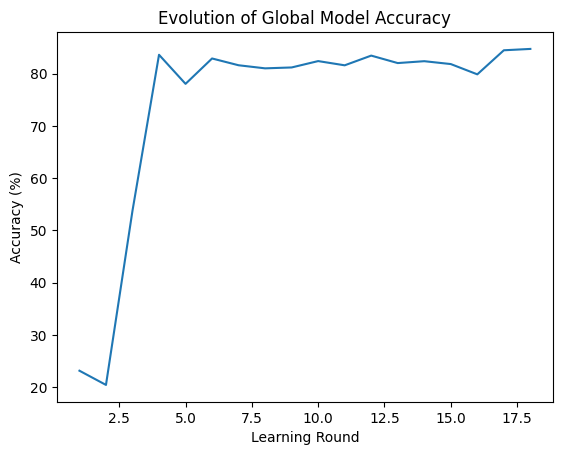

In [34]:
accuracies = []
# iterate over all rounds
for rnd in range(learningRounds):
    # print round number
    print(f"Learning Round: {rnd + 1}")
    # to save local models parameters
    params = []
    # iterate over all clients
    for client in range(clients):
        # create a local model identical to the global model
        clientModel = nn.Sequential(
                        nn.Conv2d(1, 32, kernel_size=3),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, kernel_size=3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(64 * 12 * 12, 128),
                        nn.ReLU(),
                        nn.Linear(128, 10)
                        )
        # client receives a copy of the global model current parameters
        clientModel.load_state_dict(globalModel.state_dict())
        # load the data to the model
        trainLoader = data.DataLoader(clientData[client], batch_size=10, shuffle=False)
        # client optimizer and loss function
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(clientModel.parameters(), lr=lr)
        # train model on client k for the defined local epochs
        for epoch in range(numEpochs):
            # perform forward pass and back propagation updating the local model
            for inputs, labels in trainLoader:
                optimizer.zero_grad()
                outputs = clientModel(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            # print client's k training progress
            print(f"Client {client+1} finished training for: {epoch+1} epoch(s)")
        # After model is done training, get local model parameters
        localParameters = [param.data for param in clientModel.parameters()]
        params.append(localParameters)
    # when a training round is finished, aggregate and average the parameters from all local models
    averagedParameters = [
        torch.mean(torch.stack(params), dim=0) for params in zip(*params)
    ]
    for global_param, avg_param in zip(globalModel.parameters(), averagedParameters):
        global_param.data = avg_param
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testLoader:
            outputs = globalModel(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
print(f"Training is finished after {learningRounds} federated rounds on {clients} clients!")
# Plot the evolution of global model accuracy
plt.plot(range(1, learningRounds + 1), accuracies)
plt.xlabel("Learning Round")
plt.ylabel("Accuracy (%)")
plt.title("Evolution of Global Model Accuracy")
plt.show()

# we can now evaluate the global model on testing data

In [35]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testLoader:
        images, labels = images.to(device), labels.to(device)
        outputs = globalModel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 84.76%
